In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch,torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve

import os,h5py,pickle

from models import *
from datasets.simulated_face import FaceDataset
from baseline_method_v2_1 import Our_method, calibrate_model, evaluate, inference, pickling

import warnings
warnings.filterwarnings('ignore')

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# Data

To benchmark the performance of neural networks on the task of probability estimation, we build a synthetic dataset based on UTKFace, which contains faces images and associated ages. 

Each sample in the dataset consists of a face image $x_i$ and a corresponding age $z_i$ of the person. We use the age of the $i$th person $z_i$ to assign them a risk of contracting a disease $p_i= \psi(z_i)$ for a fixed function $\psi: \mathbb{N} \rightarrow [0,1]$. Then we simulate whether the person actually contracts the illness by assigning it a label $y_i=1$ with probability $p_i$, and $y_i=0$ otherwise. The probability-estimation task is to estimate the ground-truth probability $p_i$ from the face image $x_i$, which requires learning to discriminate age and map it to the corresponding risk.

Here we use the **Uniform** case to illustrate how to apply CaPE to an early stopped model for better probability estimation.

In [5]:
# label_type in {'unif', 'sig', 'scaled', 'mid', 'step'}
# stands for Uniform, Sigmoid, Skewed, Centered, Discrete in paper

label_type = 'unif'
trainset = Face_dataset(root='./Faces_detection/',prob_type=label_type,mode = 'train',std_classifier=False)
valset = Face_dataset(root='./Faces_detection/',prob_type=label_type,mode = 'val',std_classifier=False)
testset = Face_dataset(root='./Faces_detection/',prob_type=label_type,mode = 'test',std_classifier=False)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=4)
valloader = torch.utils.data.DataLoader(
    valset, batch_size=128, shuffle=False, num_workers=4)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=4)



# Model



In [6]:

print('==> Building model..')
net = torchvision.models.resnet18(num_classes=2)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)


==> Building model..


### load early-stopped cross-entropy model weights for CaPE

In [7]:
checkpoint = torch.load(os.path.join('crossentropy', 'unif_1e-1.ckpt'))
net.load_state_dict(checkpoint['net'])

print(checkpoint.keys())


dict_keys(['train_loss', 'val_loss', 'epoch', 'error', 'ece', 'mce', 'loss', 'brier', 'brier_gt', 'gt_cel_loss', 'kl_gt_prob', 'kl_prob_gt', 'ks_error', 'net'])


# Calibrated Probability Estimation (CaPE)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-4,
                      momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=5, factor=0.5, \
#                                                                     min_lr=1e-6, verbose=True)


m_kwargs = {
        "net": net,  # early stopped network
        "optimizer": optimizer,  # optimizer for finetuning
        "train_dataset": trainset,  # train set
        "val_dataset": valset,  # validation set for finetuning stopping
        "num_epoch": 200,  # max number of epochs for finetuning
        "n_bins": 15,  # number of bins for updated probabilistic labels
        "calpertrain": 2,
        "finetune_type": "bin",
    }
# df_1 =calibrate_model(Our_method, m_kwargs=m_kwargs, test_dataset=testset)

df_1 = pd.read_csv('df_1.csv')
df_1.Name = ['CaPE','CaPE_calibrated']
df_1.Error = [32.932589,32.081046855213174]
df_1.ECE = [0.052483,0.04052140429159109]
df_1.MCE = [0.128062,0.10560663712930075]
df_1.Loss = [0.593994,0.5900166126030617]
df_1.Brier = [0.206478,0.18744435372715908]
df_1.Brier_w_gt = [0.022008,0.01847181253741694]
df_1.Loss_w_gt = [0.587081,0.5658383580010486]
df_1.KL_gt_prob = [0.053943,0.05076418782840948]
df_1.KL_prob_gt = [0.076239,0.06972990746928456]
df_1.ks_error = [0.027095,0.01756098775305924]

In [9]:
df_1

,Name,Error,ECE,MCE,Loss,Brier,Brier_w_gt,Loss_w_gt,KL_gt_prob,KL_prob_gt,ks_error
0,CaPE,32.932589,0.052483,0.128062,0.593994,0.206478,0.022008,0.587081,0.053943,0.076239,0.027095
1,CaPE_calibrated,32.081047,0.040521,0.105607,0.590017,0.187444,0.018472,0.565838,0.050764,0.069730,0.017561


# Other calibration methods 

### Temperature Scaling

In [13]:
from calibration_tools.postprocessing import TemperatureScaling

net.load_state_dict(checkpoint['net'])

temperature_kwargs = {
"temp": 1, # starting temperature, default 1
"maxiter": 50, #maximum iterations done by optimizer, however 8 iterations have been maximum.
"solver": "BFGS" #Optimization method
}

df_2 = calibrate_model(TemperatureScaling, name = 'Temperature',
                       m_kwargs = temperature_kwargs, 
                       plot_figure=False,
                       net = net, val_dataset = valset, test_dataset = testset, approach = 'multi')

In [15]:
df_2

,Name,Error,ECE,MCE,Loss,Brier,Brier_w_gt,Loss_w_gt,KL_gt_prob,KL_prob_gt,ks_error
0,Temperature,32.932589,0.052483,0.128062,0.593994,0.206478,0.022008,0.587081,0.053943,0.076239,0.027095
1,Temperature_calibrated,32.932589,0.049795,0.120298,0.592651,0.206096,0.021894,0.586263,0.053125,0.077590,0.033442


### Platt transform

In [14]:
from sklearn.linear_model import LogisticRegression 

net.load_state_dict(checkpoint['net'])
df_3 = calibrate_model(LogisticRegression, name = 'Platt Scaling',
                       m_kwargs = {}, 
                       plot_figure=False,
                       net = net, val_dataset = valset, test_dataset = testset, approach = 'multi')

In [16]:
df_3 

,Name,Error,ECE,MCE,Loss,Brier,Brier_w_gt,Loss_w_gt,KL_gt_prob,KL_prob_gt,ks_error
0,Platt Scaling,32.932589,0.052483,0.128062,0.593994,0.206478,0.022008,0.587081,0.053943,0.076239,0.027095
1,Platt Scaling_calibrated,32.374410,0.025441,0.073788,0.587439,0.203614,0.019127,0.580457,0.047319,0.075739,0.013029


In [17]:
df_final = pd.concat([df_1,df_2,df_3])
df_final

,Name,Error,ECE,MCE,Loss,Brier,Brier_w_gt,Loss_w_gt,KL_gt_prob,KL_prob_gt,ks_error
0,CaPE,32.932589,0.052483,0.128062,0.593994,0.206478,0.022008,0.587081,0.053943,0.076239,0.027095
1,CaPE_calibrated,32.081047,0.040521,0.105607,0.590017,0.187444,0.018472,0.565838,0.050764,0.069730,0.017561
0,Temperature,32.932589,0.052483,0.128062,0.593994,0.206478,0.022008,0.587081,0.053943,0.076239,0.027095
1,Temperature_calibrated,32.932589,0.049795,0.120298,0.592651,0.206096,0.021894,0.586263,0.053125,0.077590,0.033442
0,Platt Scaling,32.932589,0.052483,0.128062,0.593994,0.206478,0.022008,0.587081,0.053943,0.076239,0.027095
1,Platt Scaling_calibrated,32.374410,0.025441,0.073788,0.587439,0.203614,0.019127,0.580457,0.047319,0.075739,0.013029


# Miscalibration due to overfitting and how to avoid it


In [23]:
#restrore saved prediction output to generate Figure 4 in the paper

OUTPUT_P_DIR = 'result/'

def unpickling(file):
    return pickle.load(open(file, 'rb'))


def binned_hist_output_prob_multiple(pickled_prob,title,n_bins,distribution,save=True,save_dir = 'output_prob_plot/'):
    n = len(pickled_prob)
    color_list = ['pink','salmon','red','crimson','black']
    
    fig, axes = plt.subplots(1,n, figsize=(6*n, 4))
    
    for j in range(n):
        data_dict = unpickling(pickled_prob[j])
        val_targets_probs = data_dict['val_targets_probs']
        labels = data_dict['labels']
        gt_labels = data_dict['gt_labels']

        gt_labels_unique = np.unique(gt_labels)
        binned_gt_labels = gt_labels_unique

        x, y = val_targets_probs, gt_labels
        for i in range(binned_gt_labels.shape[0]):
            number, bins, patches = axes[j].hist(x[y==binned_gt_labels[i]],
                                                 bins=20,
                                                 color = color_list[i] , 
                                                 alpha=0.55,
                                                 label = 'p = {:.3f} '.format(binned_gt_labels[i])
                                                )
            axes[j].vlines(binned_gt_labels[i],0,1000,color = color_list[i],linewidth=3,linestyle='dotted')
            
        axes[j].set_ylabel('# samples',fontsize=24) 
        axes[j].set_ylim(0,320)
        axes[j].set_xlim(0,1)
        axes[j].set_xticks([0.1,0.3,0.5,0.7,0.9])
        for tick in axes[j].xaxis.get_major_ticks():
            tick.label.set_fontsize(18) 
        for tick in axes[j].yaxis.get_major_ticks():
            tick.label.set_fontsize(18) 
                
        axes[j].set_xlabel(r'$\hat{p}$',fontsize=24)
        if j==1:
            axes[j].set_ylim(0,850)
            
        axes[j].set_title(title[j],fontsize = 24)
        
    handles, labels = axes[j].get_legend_handles_labels()
    labels = [labels[i] for i in  [0,1,2,3,4]]   
    handles = [handles[i] for i in  [0,1,2,3,4]]   
    axes[j].legend(handles, labels, fontsize = 24, ncol = 5, bbox_to_anchor = (0.6, -0.26))
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
    if save:
        plt.savefig(save_dir+distribution+"({}).pdf".format(n),
                    format='pdf',
                    bbox_inches='tight')
        print('saved')
    
    plt.show()



def binned_scatter_output_prob_multiple(pickled_prob,title,distribution,n_bins=5,strategy='uniform',
                                        save=True,save_dir = 'output_prob_plot/'):
    n = len(pickled_prob)
    
    fig, axes = plt.subplots(1,n, figsize=(6*n, 4))
    
    for j in range(n):
        data_dict = unpickling(pickled_prob[j])
        val_targets_probs = data_dict['val_targets_probs']
        labels = data_dict['labels']
        gt_labels = data_dict['gt_labels']

        x, y = val_targets_probs, gt_labels
        prob_true, prob_pred = calibration_curve(labels, val_targets_probs,n_bins=n_bins,strategy=strategy)
        
        prob_df = pd.DataFrame(np.stack([x, y]).T, columns=[r'$\hat{p}_i$',r'$p_i$'])
        sns.scatterplot(data=prob_df, x=r'$\hat{p}_i$', y=r'$p_i$',
                        ax=axes[j],color='dodgerblue',#dodgerblue
                        alpha=0.08, size=11,legend=False
                        )
        axes[j].plot(prob_pred, prob_true,
                    'black',marker='o',ms=11,
                     linewidth=3,)
        axes[j].set_xlabel('Predicted probability', fontsize=30,)#c='crimson')
        if j==0:
            axes[j].set_ylabel('Empirical probability', fontsize=30,)#c='crimson')
        else:
            axes[j].set_ylabel('')
        for tick in axes[j].xaxis.get_major_ticks():
            tick.label.set_fontsize(40) 
        for tick in axes[j].yaxis.get_major_ticks():
            tick.label.set_fontsize(40) 
        
        axes[j].tick_params(axis='x', labelsize=24,) #grid_color='crimson',colors = 'crimson')
        axes[j].tick_params(axis='y', labelsize=24,) #grid_color='crimson',colors = 'crimson')
        axes[j].set_title(title[j],fontsize = 30,y=1.1)
        axes[j].plot(np.linspace(0,1,1000), np.linspace(0,1,1000),
                     'grey',linestyle='--',
                     linewidth=3, alpha=0.8)
        axes[j].spines['right'].set_visible(False)
        axes[j].spines['top'].set_visible(False)
        
        axes[j].text(0.02, 1, r'$p_i$',fontsize=36,color='cornflowerblue')
        axes[j].text(1.02, 0, r'$\hat{p}_i$',fontsize=36,color='cornflowerblue')

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.)
    #plt.tight_layout()
    if save:
        plt.savefig(save_dir+distribution+"scatterplot({}).pdf".format(n),
                    format='pdf',
                    bbox_inches='tight')
    plt.show()

saved


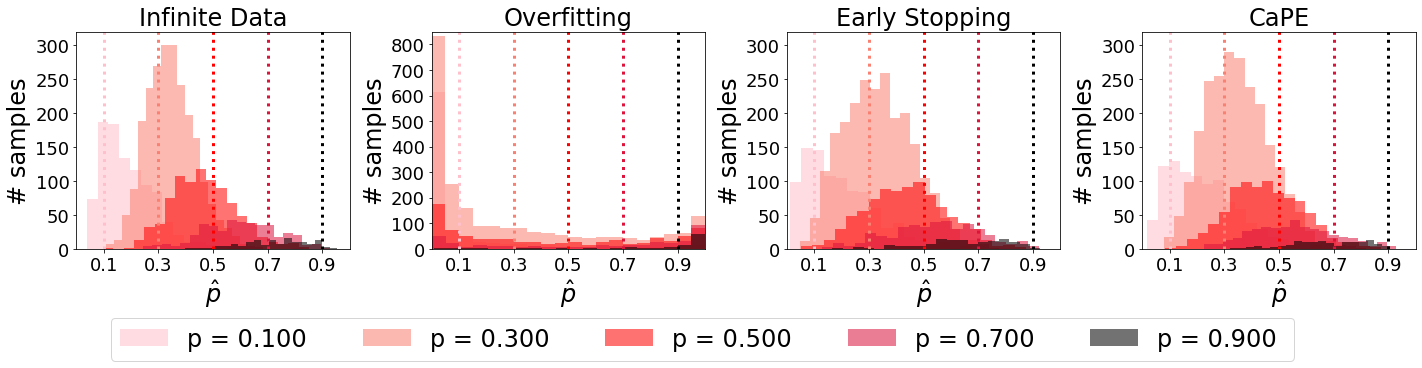

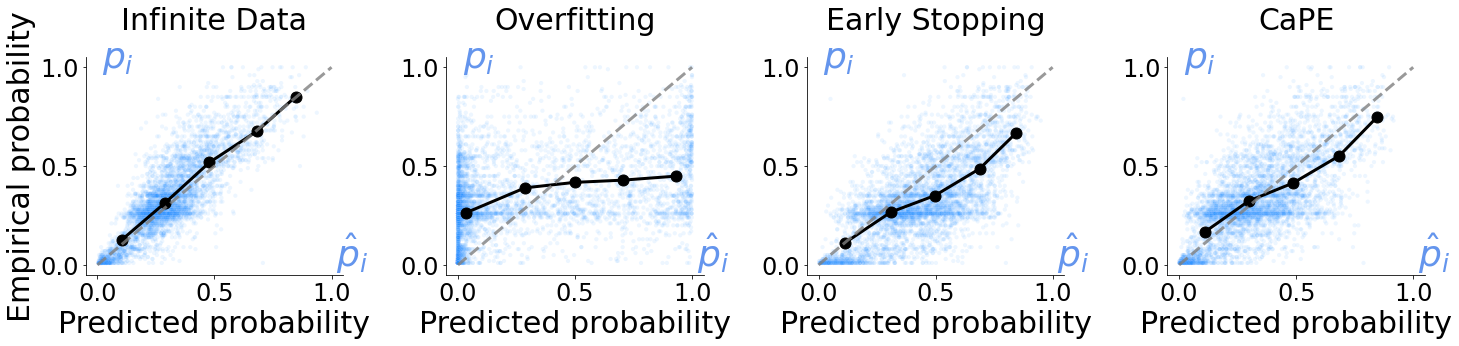

In [24]:


binned_hist_output_prob_multiple([ 
                                OUTPUT_P_DIR + 'discrete_infinite_output_prob.p', #continuous sampling to generate Infinite Data
                                OUTPUT_P_DIR + 'discrete_overfit_output_prob.p', #crossentropy overfit
                                OUTPUT_P_DIR + 'discrete_early_stop_output_prob.p', #crossentropy early stop model
                                OUTPUT_P_DIR + 'discrete_cape_bin_output_prob.p', # ours(bin) best result
                                 ],
                                 [
                                  'Infinite Data',
                                  'Overfitting',
                                  'Early Stopping',
                                  'CaPE',
                                 ],
                                 n_bins = 5,
                                 distribution='stepwise',
                                 save=True,
                                )
    
binned_scatter_output_prob_multiple([ 
                                  OUTPUT_P_DIR + 'unif_infinite_output_prob.p', #continuous sampling
                                  OUTPUT_P_DIR + 'unif_overfit_output_prob.p', #crossentropy overfit
                                  OUTPUT_P_DIR + 'unif_early_stop_output_prob.p', #crossentropy early stop model
                                  OUTPUT_P_DIR + 'unif_cape_bin_output_prob.p', # ours(bin) best result
                                 ],
                                 [
                                  'Infinite Data',
                                  'Overfitting',
                                  'Early Stopping',
                                  'CaPE',
                                 ],
                                 distribution='unif',
                                 save=True,
                                )




When trained on infinite data(i.e. resampling outcomes at each epoch according to ground-truth probabilities), neural networks trained by minimizing cross-entropy are well calibrated. In the synthetic **discrete** scenario the estimates are centered around the corresponding ground-truth probabilities (top). In the **uniform** scenario the reliability diagram shows that estimated probabilities match empirical probabilities of held-out outcomes (bottom, dashed line indicates perfect calibration). 
    
 However, when trained on fixed observed outcomes, the model eventually overfits and the probabilities collapse to either 0 or 1 (second column). This is mitigated via early stopping, which yields relatively good calibration (third column). The proposed Calibration Probability Estimation (CaPE) method exploits this to further improve the model while ensuring that the output remains well calibrated.